In [111]:
%load_ext autoreload
%autoreload 2

In [690]:
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
import nltk.stem as stem
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec
import gensim
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import category_encoders as ce
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPRegressor
import random

In [691]:
data_train = "Data_Train.csv"
data_test = "Data_Test.csv"

In [692]:
df = pd.read_csv("Data/" + data_train)
df_testing = pd.read_csv("Data/" + data_test)
df.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


Text variables : Title, sysnopsis

Categorical : Author, genre, bookCategory

composite (categorical) : Edition

real valued: Reviews, ratings

In [693]:
df.shape

(6237, 9)

In [694]:
def prepare_data(df):
    ''' cleaning data - fields Reviews, Ratings and Edtition'''
    
    df['Ratings'] = df.Ratings.str.split().str.get(0).str.replace(',', '').astype('int32')
    df['Reviews'] = df.Reviews.str.split().str.get(0).astype('float')
    df['Edition_type'] = df.Edition.str.split(',').str.get(0)
    df['Edition_year'] = df.Edition.str.split().str.get(-1)
    df = df.drop(columns=['Edition'])
    return df

In [695]:
df = prepare_data(df)
df.to_csv("Data/new_data.csv", index=None)
data = pd.read_csv("Data/new_data.csv")
data.head()

,Title,Author,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,Edition_type,Edition_year
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,4.0,8,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00,Paperback,2016
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,3.9,14,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,Paperback,2012
2,Leviathan (Penguin Classics),Thomas Hobbes,4.8,6,"""During the time men live without a common Pow...",International Relations,Humour,299.00,Paperback,1982
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,4.1,13,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,Paperback,2017
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,5.0,1,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62,Hardcover,2006


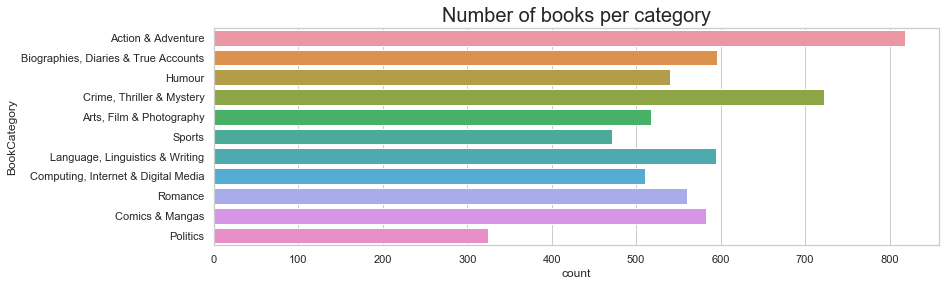

In [696]:
fig, ax = plt.subplots(figsize=(13,4))
sns.set(style="whitegrid")
sns.countplot(ax=ax, y="BookCategory", data=data).set_title("Number of books per category",fontsize=20)
plt.show()

### Converting BookCategory to one hot vector

In [697]:
dummies = pd.get_dummies(data['BookCategory'])
data = pd.concat([data, dummies], axis=1)
data.shape

(6237, 21)

Text(0.5, 1.0, 'Price of Books vs reviews')

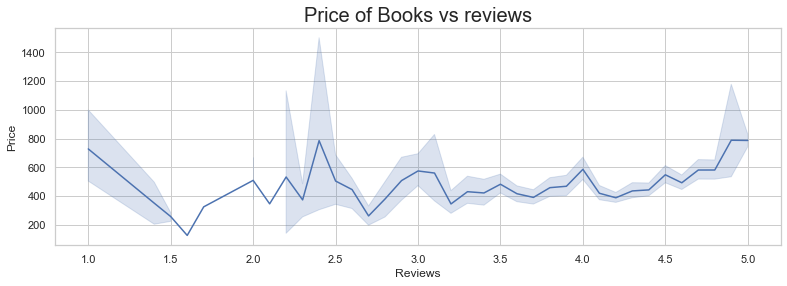

In [698]:
plt.figure(figsize=(13, 4))
sns.lineplot(x="Reviews", y="Price", data=data).set_title("Price of Books vs reviews",fontsize=20)

Text(0.5, 1.0, 'Price of Books vs No. of Ratings')

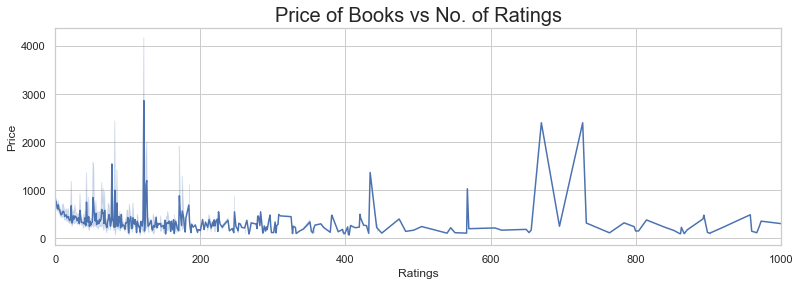

In [699]:
plt.figure(figsize=(13, 4))
ax = sns.lineplot(x="Ratings", y="Price", data=data)
ax.set_xlim([0,1000])
ax.set_title("Price of Books vs No. of Ratings",fontsize=20)

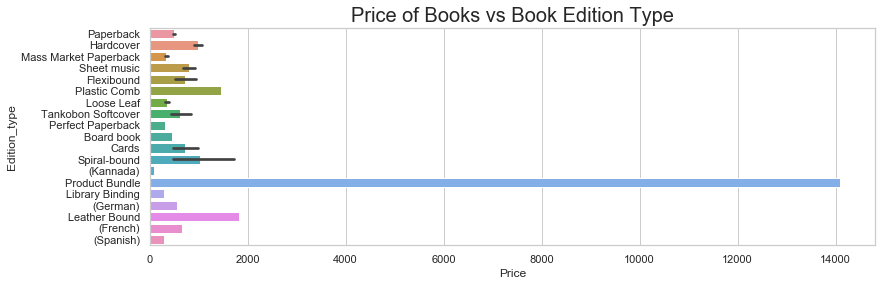

In [700]:
fig, ax = plt.subplots(figsize=(13,4))
sns.set(style="whitegrid")
sns.barplot(x="Price", y="Edition_type", data=data).set_title("Price of Books vs Book Edition Type",fontsize=20)
plt.show()

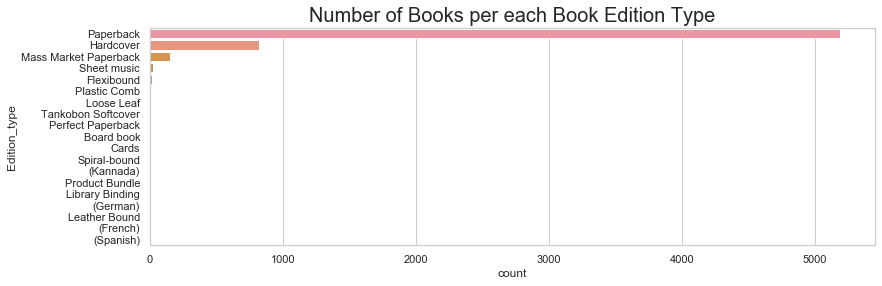

In [701]:
fig, ax = plt.subplots(figsize=(13,4))
sns.set(style="whitegrid")
sns.countplot(ax=ax, y="Edition_type", data=data).set_title("Number of Books per each Book Edition Type",fontsize=20)
plt.show()

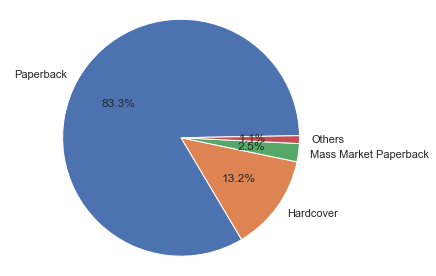

In [703]:
x = dict(data['Edition_type'].value_counts())
total = 0
for i, j in x.items():
    if j <= 24:
        total+=j
keys = [i for i, j in x.items() if j > 24]
keys.append("Others")
values = [j for i, j in x.items() if j > 24]
values.append(total)
labels = keys
sizes = values
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=1)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

##### Since top 3-4 categories cover more than 97% of the data, we convert other categories to "others"

In [704]:
counts = pd.value_counts(data['Edition_type'])
mask = data['Edition_type'].isin(counts[counts > 24].index)
data['Edition_type'][~mask] = "Other_editions"
dummies = pd.get_dummies(data['Edition_type'])
data = pd.concat([data, dummies], axis=1)
data.shape

(6237, 25)

In [705]:
counts = pd.value_counts(data['Genre'])
mask = data['Genre'].isin(counts[counts > 7].index)
data['Genre'][~mask] = "Other_genres"
dummies2 = pd.get_dummies(data['Genre'])
data = pd.concat([data, dummies2], axis=1)
data.shape

(6237, 133)

In [706]:
counts = pd.value_counts(data['Author'])
mask = data['Author'].isin(counts[counts > 2].index)
data['Author'][~mask] = "Other_authors"
dummies2 = pd.get_dummies(data['Author'])
data = pd.concat([data, dummies2], axis=1)
data.shape

(6237, 508)

In [707]:
data = data.drop(columns=['Author', 'Genre', 'Edition_type', 'BookCategory', 'Edition_year'])

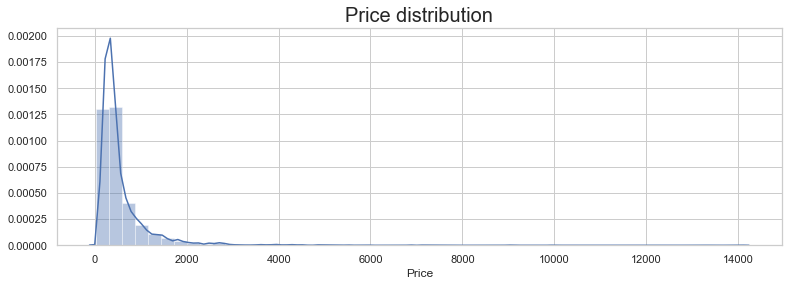

In [708]:
plt.figure(figsize=(13, 4))
sns.distplot(data['Price']).set_title("Price distribution", fontsize=20)
plt.show()

#### As we can see that the price distribution is a bit skewed, and there are several outliers as well.

In [709]:
# Removing outliers
data = data.loc[(data['Price'] <= 2000) & (data['Price'] >=100)]

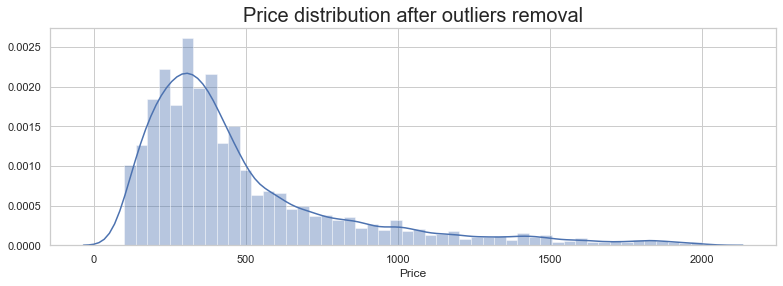

In [710]:
plt.figure(figsize=(13, 4))
sns.distplot(data['Price']).set_title("Price distribution after outliers removal", fontsize=20)
plt.show()

In [711]:
data.shape

(5874, 503)

### Add Synopsis as average word vectors to the features

In [80]:
stemmer = stem.PorterStemmer()
stop_words = stopwords.words('english')

def stem_stop(input_text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(input_text.lower())
    tokens = [x for x in tokens if not x in stop_words]
    tokens_stemmed = [stemmer.stem(x) for x in tokens]
    return tokens_stemmed

def get_mean_vector(word2vec_model, words):
    words = [word for word in words if word in word2vec_model.vocab]
    if len(words) >= 1:
        return np.mean(word2vec_model[words], axis=0)
    else:
        return np.zeroes(300)

def get_word_vectors(df):
    sentences_train = list(df)
    sentences_train = [stem_stop(i) for i in sentences_train]
    sentences_train = np.array([get_mean_vector(model, i) for i in sentences_train])
    headers = ["Wordvec"+ str(i) for i in range(300)]
#     sentences_train = pd.DataFrame(data=sentences_train, columns=headers)
    return sentences_train


model = gensim.models.KeyedVectors.load_word2vec_format('models/GoogleNews-vectors-negative300.bin', binary=True)
sentences = get_word_vectors(data['Synopsis'])
headers = ["Wordvec"+ str(i) for i in range(300)]
sentences = pd.DataFrame(data=sentences , index=data.index, columns=headers)
data = pd.concat([data, sentences], axis=1)

In [712]:
data = data.drop(columns=['Title', 'Synopsis'])
data.shape, data.columns

((5874, 501), Index(['Reviews', 'Ratings', 'Price', 'Action & Adventure',
        'Arts, Film & Photography', 'Biographies, Diaries & True Accounts',
        'Comics & Mangas', 'Computing, Internet & Digital Media',
        'Crime, Thriller & Mystery', 'Humour',
        ...
        'Walter Isaacson', 'Wilbur Smith', 'William Dalrymple',
        'William Lidwell', 'William Shakespeare', 'Wonder House Books',
        'Yashavant P. Kanetkar', 'Yashodhara Lal', 'Yuval Noah Harari',
        'ZAG Entertainment'],
       dtype='object', length=501))

In [713]:
Y = data['Price']
X = data.drop(columns=['Price'])

#### Using Binary encoding for categorical variables

In [714]:
# ce_bin = ce.BinaryEncoder(cols = ['BookCategory','Edition_year', 'Genre','Author','Edition_type'])
# X = ce_bin.fit_transform(X, Y)

In [715]:
X = normalize(X)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4699, 500), (1175, 500), (4699,), (1175,))

#### importing Decision tree regressor with max depth = 3

In [687]:
reg_model = DecisionTreeRegressor(max_depth=20)

reg_model.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [688]:
print("Train error: ", np.sqrt(mean_squared_log_error(y_train, reg_model.predict(x_train))))

predictions = list(reg_model.predict(x_test))

print("Test error: ", np.sqrt(mean_squared_log_error(y_test, predictions)))

Train error:  0.41315444126271916
Test error:  0.6130890901803395


In [223]:
def plot_train_test_error(x_train, y_train, x_test, y_test, encoding_type):

    train_errors, test_errors, depths = [], [], []

    for depth in range(2, 30):
        reg_model = DecisionTreeRegressor(max_depth=depth)
        reg_model.fit(x_train, y_train)
        train_err = np.sqrt(mean_squared_log_error(y_train, reg_model.predict(x_train)))
        test_err = np.sqrt(mean_squared_log_error(y_test, reg_model.predict(x_test)))
        train_errors.append(train_err)
        test_errors.append(test_err)
        depths.append(depth)

    d = pd.DataFrame({"train_error": train_errors, "test_error": test_errors, "depths": depths})

    builds = d['depths']
    y_stack = np.row_stack((d['train_error'], d['test_error'])) 
    fig = plt.figure(figsize=(12,5))
    fig.suptitle('Train test error with ' + encoding_type + ' encoded categorical Variables', fontsize=15)
    ax1 = fig.add_subplot(111)

    ax1.plot(builds, y_stack[0,:], label='Train error', color='c', marker='o')
    ax1.plot(builds, y_stack[1,:], label='Test error', color='g', marker='.')

    plt.xticks(builds)
    plt.xlabel('Depth')
    plt.ylabel('Error')

    handles, labels = ax1.get_legend_handles_labels()
    lgd = ax1.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.15,1))
    ax1.grid('on')

    plt.show()

#### Plot train test error for Decision tree regressor with varying max depths

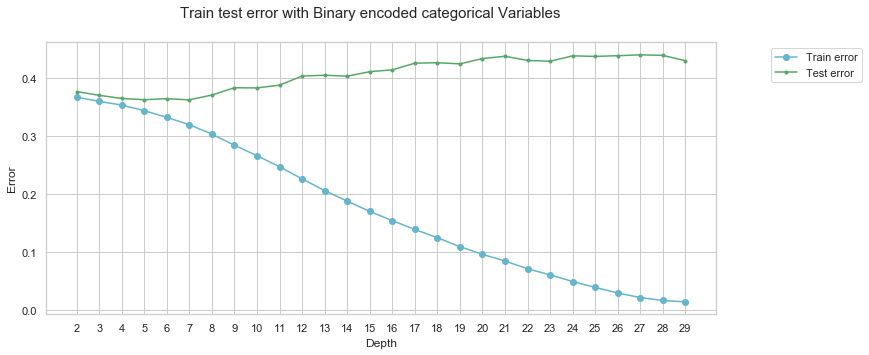

In [224]:
plot_train_test_error(x_train, y_train, x_test, y_test, 'Binary')

#### Trying multi-layer perceptron regressor

In [724]:
reg_model = MLPRegressor(verbose=True, max_iter=6000, learning_rate_init=0.001, hidden_layer_sizes=(100,))

In [725]:
reg_model.fit(x_train, y_train)

Iteration 1, loss = 178314.39033826
Iteration 2, loss = 178011.10798736
Iteration 3, loss = 177598.02895704
Iteration 4, loss = 177030.77787111
Iteration 5, loss = 176304.30242919
Iteration 6, loss = 175406.60148183
Iteration 7, loss = 174333.96365280
Iteration 8, loss = 173096.88316062
Iteration 9, loss = 171692.63875431
Iteration 10, loss = 170124.60345662
Iteration 11, loss = 168405.95129361
Iteration 12, loss = 166523.60949900
Iteration 13, loss = 164515.32074015
Iteration 14, loss = 162360.95668815
Iteration 15, loss = 160079.16427447
Iteration 16, loss = 157684.92608749
Iteration 17, loss = 155182.19825576
Iteration 18, loss = 152583.10163662
Iteration 19, loss = 149895.28777606
Iteration 20, loss = 147120.38837216
Iteration 21, loss = 144276.21212445
Iteration 22, loss = 141386.94609398
Iteration 23, loss = 138435.19488258
Iteration 24, loss = 135455.24654546
Iteration 25, loss = 132439.89508619
Iteration 26, loss = 129420.13034248
Iteration 27, loss = 126384.45234104
Iteration 

Iteration 225, loss = 45681.32887386
Iteration 226, loss = 45642.49145651
Iteration 227, loss = 45607.93395165
Iteration 228, loss = 45568.76054422
Iteration 229, loss = 45532.99612527
Iteration 230, loss = 45498.11813833
Iteration 231, loss = 45464.91206855
Iteration 232, loss = 45426.87579540
Iteration 233, loss = 45394.81926753
Iteration 234, loss = 45357.95915107
Iteration 235, loss = 45322.79215616
Iteration 236, loss = 45294.50499194
Iteration 237, loss = 45256.19722466
Iteration 238, loss = 45221.60430566
Iteration 239, loss = 45187.56343637
Iteration 240, loss = 45160.52777033
Iteration 241, loss = 45121.92706175
Iteration 242, loss = 45093.51641412
Iteration 243, loss = 45058.65105925
Iteration 244, loss = 45026.48808985
Iteration 245, loss = 44998.13045420
Iteration 246, loss = 44963.97124749
Iteration 247, loss = 44933.76270923
Iteration 248, loss = 44903.13990341
Iteration 249, loss = 44871.40575515
Iteration 250, loss = 44840.62815879
Iteration 251, loss = 44810.98255415
I

Iteration 448, loss = 41437.79770353
Iteration 449, loss = 41423.37791167
Iteration 450, loss = 41411.70848173
Iteration 451, loss = 41402.31379270
Iteration 452, loss = 41393.38650185
Iteration 453, loss = 41380.61683899
Iteration 454, loss = 41367.86472436
Iteration 455, loss = 41361.05169955
Iteration 456, loss = 41360.95478008
Iteration 457, loss = 41335.71742092
Iteration 458, loss = 41334.24432573
Iteration 459, loss = 41319.11153863
Iteration 460, loss = 41305.86849017
Iteration 461, loss = 41295.88894432
Iteration 462, loss = 41286.40672641
Iteration 463, loss = 41274.33494694
Iteration 464, loss = 41263.66278319
Iteration 465, loss = 41253.75616101
Iteration 466, loss = 41242.18353139
Iteration 467, loss = 41234.85131117
Iteration 468, loss = 41222.71187857
Iteration 469, loss = 41213.24991088
Iteration 470, loss = 41202.54302410
Iteration 471, loss = 41191.31431776
Iteration 472, loss = 41183.34255099
Iteration 473, loss = 41171.71729543
Iteration 474, loss = 41163.03970282
I

Iteration 670, loss = 39619.47786234
Iteration 671, loss = 39611.42750073
Iteration 672, loss = 39605.69583393
Iteration 673, loss = 39599.56384530
Iteration 674, loss = 39592.99297609
Iteration 675, loss = 39588.27120307
Iteration 676, loss = 39582.99853595
Iteration 677, loss = 39575.78810267
Iteration 678, loss = 39568.95242588
Iteration 679, loss = 39564.61356168
Iteration 680, loss = 39557.38962393
Iteration 681, loss = 39554.21344484
Iteration 682, loss = 39551.27587251
Iteration 683, loss = 39549.04063126
Iteration 684, loss = 39534.28838015
Iteration 685, loss = 39527.40675527
Iteration 686, loss = 39524.30739543
Iteration 687, loss = 39517.75553264
Iteration 688, loss = 39516.34195685
Iteration 689, loss = 39504.92598315
Iteration 690, loss = 39500.10538169
Iteration 691, loss = 39495.89679904
Iteration 692, loss = 39488.39232765
Iteration 693, loss = 39487.14850948
Iteration 694, loss = 39476.57709366
Iteration 695, loss = 39473.87324305
Iteration 696, loss = 39469.43216607
I

Iteration 892, loss = 38547.82212305
Iteration 893, loss = 38545.69774527
Iteration 894, loss = 38537.11103818
Iteration 895, loss = 38532.90915376
Iteration 896, loss = 38532.09145417
Iteration 897, loss = 38526.37225879
Iteration 898, loss = 38524.19857204
Iteration 899, loss = 38518.81091836
Iteration 900, loss = 38515.88479033
Iteration 901, loss = 38510.06355745
Iteration 902, loss = 38510.29660127
Iteration 903, loss = 38503.31991818
Iteration 904, loss = 38502.03409600
Iteration 905, loss = 38498.89403489
Iteration 906, loss = 38496.65046264
Iteration 907, loss = 38488.67984025
Iteration 908, loss = 38489.71053021
Iteration 909, loss = 38484.09355548
Iteration 910, loss = 38478.85135283
Iteration 911, loss = 38474.07260747
Iteration 912, loss = 38472.45861555
Iteration 913, loss = 38466.81081922
Iteration 914, loss = 38462.64579950
Iteration 915, loss = 38462.27937140
Iteration 916, loss = 38456.01955160
Iteration 917, loss = 38453.13488670
Iteration 918, loss = 38446.32947889
I

Iteration 1112, loss = 37841.98306940
Iteration 1113, loss = 37843.05139960
Iteration 1114, loss = 37830.62156148
Iteration 1115, loss = 37838.34278367
Iteration 1116, loss = 37826.61653360
Iteration 1117, loss = 37824.37418636
Iteration 1118, loss = 37825.84866089
Iteration 1119, loss = 37819.08442764
Iteration 1120, loss = 37822.85242487
Iteration 1121, loss = 37813.86594023
Iteration 1122, loss = 37812.92941665
Iteration 1123, loss = 37806.43996400
Iteration 1124, loss = 37806.25256285
Iteration 1125, loss = 37805.67717526
Iteration 1126, loss = 37801.10290579
Iteration 1127, loss = 37799.83076427
Iteration 1128, loss = 37796.50023516
Iteration 1129, loss = 37799.79779155
Iteration 1130, loss = 37795.92978414
Iteration 1131, loss = 37785.86976198
Iteration 1132, loss = 37784.31510900
Iteration 1133, loss = 37782.51876525
Iteration 1134, loss = 37784.74773750
Iteration 1135, loss = 37778.78801121
Iteration 1136, loss = 37773.17924532
Iteration 1137, loss = 37772.79279011
Iteration 11

Iteration 1328, loss = 37306.62660007
Iteration 1329, loss = 37299.38593735
Iteration 1330, loss = 37296.23000402
Iteration 1331, loss = 37294.12251493
Iteration 1332, loss = 37290.45106660
Iteration 1333, loss = 37293.12630289
Iteration 1334, loss = 37287.81049105
Iteration 1335, loss = 37285.61662505
Iteration 1336, loss = 37283.44039870
Iteration 1337, loss = 37281.09725512
Iteration 1338, loss = 37280.26780481
Iteration 1339, loss = 37275.56266525
Iteration 1340, loss = 37284.60280560
Iteration 1341, loss = 37281.65741700
Iteration 1342, loss = 37268.37213344
Iteration 1343, loss = 37268.44144714
Iteration 1344, loss = 37264.89082262
Iteration 1345, loss = 37263.35715228
Iteration 1346, loss = 37260.32262470
Iteration 1347, loss = 37263.47471310
Iteration 1348, loss = 37256.91007388
Iteration 1349, loss = 37253.28178920
Iteration 1350, loss = 37263.02996418
Iteration 1351, loss = 37246.56542062
Iteration 1352, loss = 37248.05620333
Iteration 1353, loss = 37264.28001127
Iteration 13

Iteration 1544, loss = 36828.92901269
Iteration 1545, loss = 36826.19264005
Iteration 1546, loss = 36825.66892174
Iteration 1547, loss = 36823.74071197
Iteration 1548, loss = 36820.77736648
Iteration 1549, loss = 36821.63552412
Iteration 1550, loss = 36821.50011698
Iteration 1551, loss = 36812.84635495
Iteration 1552, loss = 36811.47149024
Iteration 1553, loss = 36809.30778627
Iteration 1554, loss = 36812.45832237
Iteration 1555, loss = 36803.82038363
Iteration 1556, loss = 36805.09918861
Iteration 1557, loss = 36803.54715672
Iteration 1558, loss = 36798.63203505
Iteration 1559, loss = 36797.63389968
Iteration 1560, loss = 36794.26903152
Iteration 1561, loss = 36795.60779820
Iteration 1562, loss = 36789.80194671
Iteration 1563, loss = 36787.68876896
Iteration 1564, loss = 36784.95673275
Iteration 1565, loss = 36782.35328890
Iteration 1566, loss = 36783.04364138
Iteration 1567, loss = 36778.22603258
Iteration 1568, loss = 36776.35969888
Iteration 1569, loss = 36775.11809864
Iteration 15

Iteration 1761, loss = 36338.77126911
Iteration 1762, loss = 36338.01723853
Iteration 1763, loss = 36333.62323889
Iteration 1764, loss = 36335.30993780
Iteration 1765, loss = 36328.34915608
Iteration 1766, loss = 36326.62813531
Iteration 1767, loss = 36324.66727228
Iteration 1768, loss = 36321.06419765
Iteration 1769, loss = 36319.48337596
Iteration 1770, loss = 36317.24432865
Iteration 1771, loss = 36317.54735884
Iteration 1772, loss = 36314.61163451
Iteration 1773, loss = 36309.72611122
Iteration 1774, loss = 36307.56356749
Iteration 1775, loss = 36307.24168194
Iteration 1776, loss = 36303.42557480
Iteration 1777, loss = 36301.34350286
Iteration 1778, loss = 36298.22523142
Iteration 1779, loss = 36297.82727985
Iteration 1780, loss = 36295.15937186
Iteration 1781, loss = 36292.57937456
Iteration 1782, loss = 36287.37525600
Iteration 1783, loss = 36286.98336885
Iteration 1784, loss = 36285.01125271
Iteration 1785, loss = 36281.89938080
Iteration 1786, loss = 36278.65127933
Iteration 17

Iteration 1977, loss = 35862.15260464
Iteration 1978, loss = 35857.95105401
Iteration 1979, loss = 35843.79616008
Iteration 1980, loss = 35844.22678248
Iteration 1981, loss = 35842.04218670
Iteration 1982, loss = 35852.05247933
Iteration 1983, loss = 35839.42241940
Iteration 1984, loss = 35836.70740418
Iteration 1985, loss = 35834.97650528
Iteration 1986, loss = 35828.44174716
Iteration 1987, loss = 35831.69046595
Iteration 1988, loss = 35825.52479484
Iteration 1989, loss = 35835.74243604
Iteration 1990, loss = 35823.06525329
Iteration 1991, loss = 35821.58743801
Iteration 1992, loss = 35815.84509547
Iteration 1993, loss = 35814.04422090
Iteration 1994, loss = 35829.77940186
Iteration 1995, loss = 35811.02048885
Iteration 1996, loss = 35809.82691621
Iteration 1997, loss = 35813.93196060
Iteration 1998, loss = 35804.13622629
Iteration 1999, loss = 35803.80707577
Iteration 2000, loss = 35798.89838615
Iteration 2001, loss = 35797.30187835
Iteration 2002, loss = 35802.77651046
Iteration 20

Iteration 2193, loss = 35385.57784553
Iteration 2194, loss = 35382.24928985
Iteration 2195, loss = 35383.26150394
Iteration 2196, loss = 35379.20093079
Iteration 2197, loss = 35379.61853043
Iteration 2198, loss = 35379.38546095
Iteration 2199, loss = 35376.09583638
Iteration 2200, loss = 35370.18956691
Iteration 2201, loss = 35367.47306745
Iteration 2202, loss = 35364.42968629
Iteration 2203, loss = 35367.89094242
Iteration 2204, loss = 35359.61170015
Iteration 2205, loss = 35359.45549305
Iteration 2206, loss = 35361.90365180
Iteration 2207, loss = 35359.00899248
Iteration 2208, loss = 35357.21046247
Iteration 2209, loss = 35349.35628772
Iteration 2210, loss = 35348.75459718
Iteration 2211, loss = 35355.11695148
Iteration 2212, loss = 35342.14268734
Iteration 2213, loss = 35353.15662282
Iteration 2214, loss = 35343.74204767
Iteration 2215, loss = 35339.95368234
Iteration 2216, loss = 35340.03879518
Iteration 2217, loss = 35340.07868744
Iteration 2218, loss = 35329.89332425
Iteration 22

Iteration 2410, loss = 34947.00221945
Iteration 2411, loss = 34960.82058093
Iteration 2412, loss = 34940.74409169
Iteration 2413, loss = 34936.16688338
Iteration 2414, loss = 34936.70200013
Iteration 2415, loss = 34935.92901683
Iteration 2416, loss = 34931.10896142
Iteration 2417, loss = 34928.37945462
Iteration 2418, loss = 34928.07520943
Iteration 2419, loss = 34923.58751732
Iteration 2420, loss = 34927.16988643
Iteration 2421, loss = 34922.29380474
Iteration 2422, loss = 34922.29738731
Iteration 2423, loss = 34916.49075063
Iteration 2424, loss = 34915.86810762
Iteration 2425, loss = 34914.06123607
Iteration 2426, loss = 34916.02096634
Iteration 2427, loss = 34914.23129745
Iteration 2428, loss = 34907.42454936
Iteration 2429, loss = 34904.91510809
Iteration 2430, loss = 34922.76104418
Iteration 2431, loss = 34899.91716728
Iteration 2432, loss = 34899.36804540
Iteration 2433, loss = 34898.36675571
Iteration 2434, loss = 34897.95680516
Iteration 2435, loss = 34892.28039294
Iteration 24

Iteration 2626, loss = 34519.05001118
Iteration 2627, loss = 34520.15884389
Iteration 2628, loss = 34515.56630268
Iteration 2629, loss = 34513.46953361
Iteration 2630, loss = 34512.38485344
Iteration 2631, loss = 34512.30776300
Iteration 2632, loss = 34513.09561212
Iteration 2633, loss = 34507.71233876
Iteration 2634, loss = 34505.01596548
Iteration 2635, loss = 34503.08502750
Iteration 2636, loss = 34501.57176565
Iteration 2637, loss = 34499.52654205
Iteration 2638, loss = 34497.06122026
Iteration 2639, loss = 34497.16942867
Iteration 2640, loss = 34492.65822776
Iteration 2641, loss = 34492.42589752
Iteration 2642, loss = 34488.63633113
Iteration 2643, loss = 34493.50490342
Iteration 2644, loss = 34487.80319168
Iteration 2645, loss = 34485.52162313
Iteration 2646, loss = 34481.71431542
Iteration 2647, loss = 34493.71387249
Iteration 2648, loss = 34491.02859625
Iteration 2649, loss = 34479.85015102
Iteration 2650, loss = 34475.13080691
Iteration 2651, loss = 34472.11380275
Iteration 26

Iteration 2842, loss = 34133.14069565
Iteration 2843, loss = 34128.85148183
Iteration 2844, loss = 34129.43224382
Iteration 2845, loss = 34131.91359920
Iteration 2846, loss = 34126.86678664
Iteration 2847, loss = 34130.63269765
Iteration 2848, loss = 34119.53088399
Iteration 2849, loss = 34125.13561734
Iteration 2850, loss = 34118.01017577
Iteration 2851, loss = 34114.53204065
Iteration 2852, loss = 34117.69032836
Iteration 2853, loss = 34113.08484299
Iteration 2854, loss = 34111.37469321
Iteration 2855, loss = 34111.69238994
Iteration 2856, loss = 34108.71554900
Iteration 2857, loss = 34111.01478366
Iteration 2858, loss = 34114.36800536
Iteration 2859, loss = 34104.97133341
Iteration 2860, loss = 34103.84224315
Iteration 2861, loss = 34097.93252974
Iteration 2862, loss = 34098.91999821
Iteration 2863, loss = 34106.27451332
Iteration 2864, loss = 34094.37939663
Iteration 2865, loss = 34092.90949819
Iteration 2866, loss = 34094.70380686
Iteration 2867, loss = 34087.90647041
Iteration 28

Iteration 3059, loss = 33775.23778196
Iteration 3060, loss = 33775.92059803
Iteration 3061, loss = 33771.20203863
Iteration 3062, loss = 33770.03474388
Iteration 3063, loss = 33773.48677808
Iteration 3064, loss = 33765.27692935
Iteration 3065, loss = 33767.59753245
Iteration 3066, loss = 33763.19704337
Iteration 3067, loss = 33764.67538361
Iteration 3068, loss = 33765.05133492
Iteration 3069, loss = 33762.25814729
Iteration 3070, loss = 33759.66115849
Iteration 3071, loss = 33757.12120041
Iteration 3072, loss = 33758.52270366
Iteration 3073, loss = 33750.41130469
Iteration 3074, loss = 33751.85264537
Iteration 3075, loss = 33749.43395850
Iteration 3076, loss = 33751.37590344
Iteration 3077, loss = 33744.72667717
Iteration 3078, loss = 33749.91036064
Iteration 3079, loss = 33742.80568998
Iteration 3080, loss = 33748.33540494
Iteration 3081, loss = 33746.91959070
Iteration 3082, loss = 33738.97805647
Iteration 3083, loss = 33739.64361515
Iteration 3084, loss = 33734.30329317
Iteration 30

Iteration 3275, loss = 33451.79752548
Iteration 3276, loss = 33445.00572238
Iteration 3277, loss = 33444.60373147
Iteration 3278, loss = 33441.73746886
Iteration 3279, loss = 33443.06003115
Iteration 3280, loss = 33446.36675509
Iteration 3281, loss = 33441.98425660
Iteration 3282, loss = 33435.03019524
Iteration 3283, loss = 33439.34416743
Iteration 3284, loss = 33433.56276643
Iteration 3285, loss = 33438.46228986
Iteration 3286, loss = 33431.91078527
Iteration 3287, loss = 33428.35911642
Iteration 3288, loss = 33428.01089392
Iteration 3289, loss = 33431.43853489
Iteration 3290, loss = 33433.74348108
Iteration 3291, loss = 33426.99146578
Iteration 3292, loss = 33426.13875095
Iteration 3293, loss = 33424.22286164
Iteration 3294, loss = 33423.28671124
Iteration 3295, loss = 33420.57333076
Iteration 3296, loss = 33415.69778084
Iteration 3297, loss = 33417.84346835
Iteration 3298, loss = 33413.67836601
Iteration 3299, loss = 33411.55187567
Iteration 3300, loss = 33412.07438095
Iteration 33

Iteration 3491, loss = 33150.14772437
Iteration 3492, loss = 33145.34907601
Iteration 3493, loss = 33139.14084067
Iteration 3494, loss = 33138.13106204
Iteration 3495, loss = 33137.99553690
Iteration 3496, loss = 33138.97233564
Iteration 3497, loss = 33136.82724528
Iteration 3498, loss = 33138.28885218
Iteration 3499, loss = 33130.58363585
Iteration 3500, loss = 33128.98700075
Iteration 3501, loss = 33130.18253567
Iteration 3502, loss = 33124.98736305
Iteration 3503, loss = 33124.53951795
Iteration 3504, loss = 33123.72591723
Iteration 3505, loss = 33129.33277165
Iteration 3506, loss = 33124.47012166
Iteration 3507, loss = 33119.80781817
Iteration 3508, loss = 33121.15658819
Iteration 3509, loss = 33127.34770548
Iteration 3510, loss = 33118.62255289
Iteration 3511, loss = 33117.41011973
Iteration 3512, loss = 33118.84540311
Iteration 3513, loss = 33110.38117599
Iteration 3514, loss = 33116.62626430
Iteration 3515, loss = 33115.73403402
Iteration 3516, loss = 33110.52891060
Iteration 35

Iteration 3707, loss = 32857.94363626
Iteration 3708, loss = 32854.65537639
Iteration 3709, loss = 32863.35419194
Iteration 3710, loss = 32857.75984336
Iteration 3711, loss = 32856.77744474
Iteration 3712, loss = 32853.24643575
Iteration 3713, loss = 32851.19640277
Iteration 3714, loss = 32852.12983392
Iteration 3715, loss = 32850.59075154
Iteration 3716, loss = 32846.25275380
Iteration 3717, loss = 32848.07983056
Iteration 3718, loss = 32842.99305414
Iteration 3719, loss = 32842.26282862
Iteration 3720, loss = 32839.35854061
Iteration 3721, loss = 32843.82991658
Iteration 3722, loss = 32838.70067210
Iteration 3723, loss = 32836.37160015
Iteration 3724, loss = 32843.91744581
Iteration 3725, loss = 32840.51168832
Iteration 3726, loss = 32834.72803585
Iteration 3727, loss = 32834.44188923
Iteration 3728, loss = 32838.96882575
Iteration 3729, loss = 32837.86632321
Iteration 3730, loss = 32828.17688609
Iteration 3731, loss = 32828.06612167
Iteration 3732, loss = 32829.60512860
Iteration 37

Iteration 3923, loss = 32591.63509577
Iteration 3924, loss = 32598.90522754
Iteration 3925, loss = 32592.68227271
Iteration 3926, loss = 32591.88068981
Iteration 3927, loss = 32590.11233576
Iteration 3928, loss = 32587.28714570
Iteration 3929, loss = 32608.36321242
Iteration 3930, loss = 32582.34690759
Iteration 3931, loss = 32593.65961766
Iteration 3932, loss = 32584.44750783
Iteration 3933, loss = 32582.63255355
Iteration 3934, loss = 32581.13533421
Iteration 3935, loss = 32583.84546692
Iteration 3936, loss = 32583.41626128
Iteration 3937, loss = 32585.89602418
Iteration 3938, loss = 32576.62366099
Iteration 3939, loss = 32577.51379886
Iteration 3940, loss = 32572.48880983
Iteration 3941, loss = 32572.12145770
Iteration 3942, loss = 32572.65130743
Iteration 3943, loss = 32576.71781342
Iteration 3944, loss = 32573.92875270
Iteration 3945, loss = 32568.50232583
Iteration 3946, loss = 32568.91688702
Iteration 3947, loss = 32565.17015159
Iteration 3948, loss = 32564.19003723
Iteration 39

Iteration 4139, loss = 32343.54831788
Iteration 4140, loss = 32348.60160346
Iteration 4141, loss = 32350.25591281
Iteration 4142, loss = 32340.59740236
Iteration 4143, loss = 32342.37373046
Iteration 4144, loss = 32338.47010353
Iteration 4145, loss = 32334.93955638
Iteration 4146, loss = 32335.56787582
Iteration 4147, loss = 32331.77319448
Iteration 4148, loss = 32330.60589340
Iteration 4149, loss = 32331.31025718
Iteration 4150, loss = 32329.72079143
Iteration 4151, loss = 32329.24164062
Iteration 4152, loss = 32331.12349228
Iteration 4153, loss = 32330.91631029
Iteration 4154, loss = 32325.38482632
Iteration 4155, loss = 32324.68699789
Iteration 4156, loss = 32323.43848560
Iteration 4157, loss = 32324.99957152
Iteration 4158, loss = 32323.20388520
Iteration 4159, loss = 32319.26689028
Iteration 4160, loss = 32321.48832410
Iteration 4161, loss = 32326.85858426
Iteration 4162, loss = 32320.97723173
Iteration 4163, loss = 32323.95170731
Iteration 4164, loss = 32316.06990239
Iteration 41

Iteration 4355, loss = 32110.12759417
Iteration 4356, loss = 32112.71340709
Iteration 4357, loss = 32110.24400521
Iteration 4358, loss = 32107.52556689
Iteration 4359, loss = 32120.02325894
Iteration 4360, loss = 32109.01461469
Iteration 4361, loss = 32108.45895677
Iteration 4362, loss = 32107.46532351
Iteration 4363, loss = 32104.53985084
Iteration 4364, loss = 32099.87853194
Iteration 4365, loss = 32102.49126680
Iteration 4366, loss = 32097.56645876
Iteration 4367, loss = 32101.27940283
Iteration 4368, loss = 32099.20326677
Iteration 4369, loss = 32096.45794308
Iteration 4370, loss = 32101.18384648
Iteration 4371, loss = 32100.75697025
Iteration 4372, loss = 32091.21170084
Iteration 4373, loss = 32095.48252930
Iteration 4374, loss = 32090.79601214
Iteration 4375, loss = 32091.05875023
Iteration 4376, loss = 32088.35419430
Iteration 4377, loss = 32094.92586816
Iteration 4378, loss = 32090.31832971
Iteration 4379, loss = 32085.91096449
Iteration 4380, loss = 32083.65043174
Iteration 43

Iteration 4571, loss = 31901.51298354
Iteration 4572, loss = 31896.44011136
Iteration 4573, loss = 31895.12069568
Iteration 4574, loss = 31888.99760699
Iteration 4575, loss = 31890.66210271
Iteration 4576, loss = 31887.57874533
Iteration 4577, loss = 31885.15698102
Iteration 4578, loss = 31886.19452042
Iteration 4579, loss = 31885.16238702
Iteration 4580, loss = 31882.60261468
Iteration 4581, loss = 31881.10999699
Iteration 4582, loss = 31879.27624602
Iteration 4583, loss = 31885.91032955
Iteration 4584, loss = 31885.87799881
Iteration 4585, loss = 31878.66628657
Iteration 4586, loss = 31876.31099139
Iteration 4587, loss = 31875.51625594
Iteration 4588, loss = 31875.03472601
Iteration 4589, loss = 31873.84435136
Iteration 4590, loss = 31871.82789072
Iteration 4591, loss = 31874.56773555
Iteration 4592, loss = 31884.31753635
Iteration 4593, loss = 31877.22070915
Iteration 4594, loss = 31868.37162042
Iteration 4595, loss = 31869.93866535
Iteration 4596, loss = 31866.99864783
Iteration 45

Iteration 4787, loss = 31691.82192740
Iteration 4788, loss = 31688.07148491
Iteration 4789, loss = 31690.18630158
Iteration 4790, loss = 31692.30253036
Iteration 4791, loss = 31686.96723805
Iteration 4792, loss = 31684.35254622
Iteration 4793, loss = 31687.20769444
Iteration 4794, loss = 31687.09958428
Iteration 4795, loss = 31682.19982404
Iteration 4796, loss = 31677.31013299
Iteration 4797, loss = 31684.66995332
Iteration 4798, loss = 31680.78622220
Iteration 4799, loss = 31676.89308624
Iteration 4800, loss = 31677.72539190
Iteration 4801, loss = 31677.50431561
Iteration 4802, loss = 31674.15548932
Iteration 4803, loss = 31680.66707011
Iteration 4804, loss = 31672.96864317
Iteration 4805, loss = 31675.71674708
Iteration 4806, loss = 31671.13073620
Iteration 4807, loss = 31669.37232575
Iteration 4808, loss = 31676.54662911
Iteration 4809, loss = 31667.76303181
Iteration 4810, loss = 31668.79213132
Iteration 4811, loss = 31671.21561578
Iteration 4812, loss = 31668.39773586
Iteration 48

Iteration 5004, loss = 31498.26580462
Iteration 5005, loss = 31496.04520275
Iteration 5006, loss = 31500.05007626
Iteration 5007, loss = 31494.87166474
Iteration 5008, loss = 31492.34185215
Iteration 5009, loss = 31509.49858504
Iteration 5010, loss = 31491.65634575
Iteration 5011, loss = 31492.58289900
Iteration 5012, loss = 31492.68987433
Iteration 5013, loss = 31494.45825408
Iteration 5014, loss = 31494.91807908
Iteration 5015, loss = 31491.03804035
Iteration 5016, loss = 31491.14496719
Iteration 5017, loss = 31489.03363823
Iteration 5018, loss = 31484.97618058
Iteration 5019, loss = 31487.81297617
Iteration 5020, loss = 31487.65658998
Iteration 5021, loss = 31482.12853564
Iteration 5022, loss = 31493.36222954
Iteration 5023, loss = 31484.20252786
Iteration 5024, loss = 31481.48531534
Iteration 5025, loss = 31482.19754168
Iteration 5026, loss = 31480.55526063
Iteration 5027, loss = 31480.03466841
Iteration 5028, loss = 31480.28099721
Iteration 5029, loss = 31477.33533983
Iteration 50

Iteration 5220, loss = 31318.24015319
Iteration 5221, loss = 31319.04277724
Iteration 5222, loss = 31315.81302425
Iteration 5223, loss = 31319.99826365
Iteration 5224, loss = 31313.32936652
Iteration 5225, loss = 31322.48071570
Iteration 5226, loss = 31326.42122677
Iteration 5227, loss = 31313.18608454
Iteration 5228, loss = 31315.78619047
Iteration 5229, loss = 31313.36751224
Iteration 5230, loss = 31312.83019717
Iteration 5231, loss = 31341.86684762
Iteration 5232, loss = 31314.12717270
Iteration 5233, loss = 31309.38993757
Iteration 5234, loss = 31306.53667189
Iteration 5235, loss = 31312.06414907
Iteration 5236, loss = 31312.77361733
Iteration 5237, loss = 31314.16214329
Iteration 5238, loss = 31313.60919554
Iteration 5239, loss = 31305.65439106
Iteration 5240, loss = 31302.96238747
Iteration 5241, loss = 31303.82259982
Iteration 5242, loss = 31301.12530219
Iteration 5243, loss = 31307.84675538
Iteration 5244, loss = 31300.04925469
Iteration 5245, loss = 31298.05457773
Iteration 52

Iteration 5436, loss = 31149.28736263
Iteration 5437, loss = 31148.04313696
Iteration 5438, loss = 31152.06272654
Iteration 5439, loss = 31146.92336294
Iteration 5440, loss = 31146.49593515
Iteration 5441, loss = 31149.62357805
Iteration 5442, loss = 31142.91470717
Iteration 5443, loss = 31143.19328420
Iteration 5444, loss = 31147.36879176
Iteration 5445, loss = 31142.08114285
Iteration 5446, loss = 31146.00730741
Iteration 5447, loss = 31142.49065423
Iteration 5448, loss = 31142.22016787
Iteration 5449, loss = 31147.58884340
Iteration 5450, loss = 31143.26534105
Iteration 5451, loss = 31143.04560728
Iteration 5452, loss = 31139.67356621
Iteration 5453, loss = 31138.43245737
Iteration 5454, loss = 31136.11740375
Iteration 5455, loss = 31137.02050258
Iteration 5456, loss = 31139.13219063
Iteration 5457, loss = 31148.42449583
Iteration 5458, loss = 31141.91302985
Iteration 5459, loss = 31133.05918997
Iteration 5460, loss = 31133.02326951
Iteration 5461, loss = 31129.53300677
Iteration 54

Iteration 5652, loss = 30986.14993615
Iteration 5653, loss = 30986.27283471
Iteration 5654, loss = 30986.09546951
Iteration 5655, loss = 30985.45774413
Iteration 5656, loss = 30991.83455024
Iteration 5657, loss = 30980.68737599
Iteration 5658, loss = 30978.55140294
Iteration 5659, loss = 30992.60076238
Iteration 5660, loss = 30979.45254801
Iteration 5661, loss = 30978.19697438
Iteration 5662, loss = 30977.17419701
Iteration 5663, loss = 30976.41836563
Iteration 5664, loss = 30975.95851051
Iteration 5665, loss = 30978.00036010
Iteration 5666, loss = 30979.55792712
Iteration 5667, loss = 30979.15730185
Iteration 5668, loss = 30971.83811108
Iteration 5669, loss = 30973.26559695
Iteration 5670, loss = 30971.33190713
Iteration 5671, loss = 30971.97772350
Iteration 5672, loss = 30971.22056331
Iteration 5673, loss = 30970.73802171
Iteration 5674, loss = 30981.71319560
Iteration 5675, loss = 30971.06135891
Iteration 5676, loss = 30968.43593053
Iteration 5677, loss = 30968.73227193
Iteration 56

Iteration 5868, loss = 30829.58802726
Iteration 5869, loss = 30826.14042912
Iteration 5870, loss = 30827.52680650
Iteration 5871, loss = 30825.94813940
Iteration 5872, loss = 30826.80942569
Iteration 5873, loss = 30828.71851525
Iteration 5874, loss = 30828.36661994
Iteration 5875, loss = 30821.07752348
Iteration 5876, loss = 30821.71880305
Iteration 5877, loss = 30819.24310351
Iteration 5878, loss = 30821.29743001
Iteration 5879, loss = 30828.55421133
Iteration 5880, loss = 30816.03490280
Iteration 5881, loss = 30817.92372534
Iteration 5882, loss = 30817.74840104
Iteration 5883, loss = 30817.15509433
Iteration 5884, loss = 30822.31554910
Iteration 5885, loss = 30815.37328162
Iteration 5886, loss = 30817.30393483
Iteration 5887, loss = 30812.52876984
Iteration 5888, loss = 30821.31193499
Iteration 5889, loss = 30815.25937750
Iteration 5890, loss = 30813.21503013
Iteration 5891, loss = 30819.95510924
Iteration 5892, loss = 30812.19050307
Iteration 5893, loss = 30807.86814492
Iteration 58

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=6000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

In [721]:
print("Train error: ", np.sqrt(mean_squared_log_error(y_train, reg_model.predict(x_train))))

Train error:  0.5594132471615889


In [722]:
predictions = list(reg_model.predict(x_test))

In [723]:
print("Test error: ", np.sqrt(mean_squared_log_error(y_test, predictions)))

Test error:  0.8245947866467275
